### Import packages

In [1]:
# General packages
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame 
import h5py
import seaborn as sns
import tensorflow as tf

# Numerical packages
import matplotlib
import sklearn
import itertools
from tqdm import tqdm
from scipy import stats, integrate
from scipy.optimize import curve_fit
import scipy.constants as const
from numpy.linalg import inv

# Import KDE
from sklearn.neighbors import KernelDensity

# MCMC
import emcee

# Splines
from scipy.interpolate import interp1d, BSpline, PchipInterpolator
#from csaps import csaps

# Nested sampling
import nestle

# Boosted decision tree packages
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb 
import xgboost as xgb 
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import mean_squared_error
import shap

# Neural network
from keras.models import Sequential
from keras.layers import Dense
import keras
from sklearn.inspection import permutation_importance
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.layers import Dropout

# Random Forets
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score # for cross-validation


# Baysian optimization 
from bayes_opt import BayesianOptimization


# Random search
from sklearn.model_selection import RandomizedSearchCV, KFold



# Data preprocessing 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from datetime import datetime 
import time

# Fit og plot packages
from iminuit import Minuit
# sys.path.append('C:/Users/marti/Google Drev/Uni/Pyhton/External_Functions')
# from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
# from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

### Pretty plotting routines

In [2]:
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    #plt.rcParams['axes.formatter.limits'] = (-1,3)
    #plt.rcParams['axes.linewidth'] = 2.25
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)


### Import data 

In [3]:
todrop = ['Particle ID','Sample',
          'Calibration Factor',
          'Calibration Image',
          'Camera',
          'Capture X',
          'Capture Y',
          'Date',
          'Elapsed Time',
          'Filter Score',
          'Image File',
          'Image Height',
          'Image Width',
          'Image X',
          'Image Y',
          'Source Image',
          'Time',
          'Timestamp',
          'imgpaths']

df_camp = pd.read_csv('train\camp.csv').drop(columns=todrop)
df_corylus = pd.read_csv('train\corylus.csv').drop(columns=todrop)
df_dust = pd.read_csv('train\dust.csv').drop(columns=todrop)
df_grim = pd.read_csv('train\grim.csv').drop(columns=todrop)
df_qrob = pd.read_csv('train\qrob.csv').drop(columns=todrop)
df_qsub = pd.read_csv('train\qsub.csv').drop(columns=todrop)

l = len(df_corylus)
df = [df_camp.sample(n=l,random_state=42),df_corylus.sample(n=l,random_state=42),
      df_dust.sample(n=l,random_state=42),df_grim.sample(n=l,random_state=42),
      df_qrob.sample(n=l,random_state=42),df_qsub.sample(n=l,random_state=42)]
path = ['camp','corylus','dust','grim','qrob','qsub']
for i in range(len(path)):
    print(path[i]+': meta data shape:'+str(df[i].shape))
    
    
data_all = pd.concat(df)
label_all = np.concatenate((np.zeros(l,dtype=np.uint8),np.ones(l,dtype=np.uint8),
                           np.ones(l,dtype=np.uint8)*np.uint8(2),
                           np.ones(l,dtype=np.uint8)*np.uint8(3),
                           np.ones(l,dtype=np.uint8)*np.uint8(4),
                           np.ones(l,dtype=np.uint8)*np.uint8(5)))
data_all.shape,label_all.shape

camp: meta data shape:(7824, 39)
corylus: meta data shape:(7824, 39)
dust: meta data shape:(7824, 39)
grim: meta data shape:(7824, 39)
qrob: meta data shape:(7824, 39)
qsub: meta data shape:(7824, 39)


((46944, 39), (46944,))

In [4]:
data_all

,Area (ABD),Area (Filled),Aspect Ratio,Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Circle Fit,Circularity,Circularity (Hu),Compactness,...,Sphere Complement,Sphere Count,Sphere Unknown,Sphere Volume,Sum Intensity,Symmetry,Transparency,Volume (ABD),Volume (ESD),Width
729,69.15,69.75,0.54,416.94,336.64,432.59,0.45,0.64,0.78,1.57,...,317.69,1,0.0,27.73,79171.0,0.68,0.16,432.58710,742.4006,8.31
9654,41.27,41.27,0.19,95.41,103.72,199.43,0.00,0.22,0.27,4.57,...,0.00,7,0.0,809.79,68945.0,0.49,0.53,199.43190,1869.2090,4.04
46010,22.35,22.35,0.43,87.01,54.72,79.47,0.36,0.57,0.64,1.75,...,231.92,1,0.0,2.63,40589.0,0.38,0.24,79.47418,180.4325,3.86
55280,145.11,145.11,0.75,1535.35,1256.12,1314.90,0.59,0.77,0.90,1.30,...,15.16,3,0.0,740.10,121179.0,0.62,0.10,1314.89800,1782.2360,12.79
36956,310.75,364.35,0.57,3430.69,4417.86,4120.88,0.35,0.54,0.79,1.85,...,0.00,6,0.0,2234.24,402946.0,0.67,0.24,4120.88200,9279.0320,16.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263,331.52,335.95,0.90,4232.34,4408.24,4540.79,0.76,0.72,0.99,1.40,...,0.00,1,0.0,4936.76,287476.0,0.77,0.04,4540.79000,5149.8180,19.68
4538,1340.51,1340.51,0.92,26819.74,35920.73,36920.48,0.75,0.64,0.99,1.55,...,0.00,1,0.0,65466.30,967420.0,0.75,0.04,36920.48000,42287.2700,40.17
6175,1347.12,1349.77,0.91,28009.30,35700.56,37194.22,0.70,0.66,0.99,1.51,...,0.00,1,0.0,36860.42,1055599.0,0.76,0.02,37194.22000,39873.0300,40.01
10370,1195.99,1201.42,0.92,15481.33,30717.43,31114.00,0.35,0.42,0.98,2.41,...,0.00,1,0.0,29516.80,1086826.0,0.54,0.04,31114.00000,35276.6300,38.12


### Inspect data 

In [5]:
# Split the data set and labels into train, validation and test set
test_size = 0.2
val_size = 0.2
num_classes=6
x_train_val,x_test,y_train_val,y_test=train_test_split(data_all \
                                               ,label_all,test_size=test_size,random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size=val_size,random_state=42)

print("Training set:")
print(" > Meta_data:", x_train.shape)
print(" > labels:", y_train.shape)
print("Validation set:")
print(" > Meta_data:", x_val.shape)
print(" > labels:", y_val.shape)
print("Test set:")
print(" > Meta_data:", x_test.shape)
print(" > labels:", y_test.shape)

Training set:
 > Meta_data: (30044, 39)
 > labels: (30044,)
Validation set:
 > Meta_data: (7511, 39)
 > labels: (7511,)
Test set:
 > Meta_data: (9389, 39)
 > labels: (9389,)


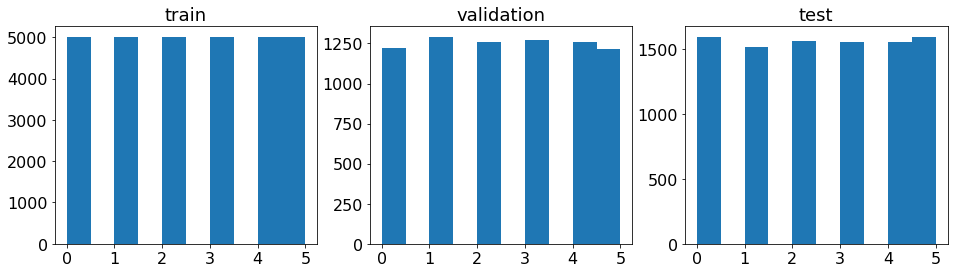

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(y_train); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(num_classes)); ax[0].tick_params(axis='both', which='major', labelsize=16);
ax[1].hist(y_val); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(num_classes)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(y_test); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(num_classes)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

## Creat the tree

In [7]:
## Training the algorithm

# Putting the training and validation set into lightgbm format
train_data=lgb.Dataset(x_train,label=y_train)
val_data=lgb.Dataset(x_val,label=y_val)

#setting parameters for lightgbm, which is done by initial guess
param = {'num_leaves':180, 'objective':'multiclass','num_class':num_classes, 'max_depth':6\
         ,'learning_rate':1e-2,'max_bin':200,'n_estimators':500}
# the metrics is used to evaluate each iteration adn thus they 
# are used as the optimization values
param['metric'] = ['']

#training our model using light gbm
start=datetime.now()
lgbm=lgb.train(param,train_data,valid_sets=[val_data],
              early_stopping_rounds=50, verbose_eval=1000);


# lgbm = lgb.LGBMClassifier(loss_function= 'Logloss', 
#                            custom_metric=['Accuracy','AUC'])
# lgbm.fit(x_train, y_train, eval_set=(x_val, y_val), feature_name='auto',
#           categorical_feature = 'auto', verbose=50)

stop=datetime.now()

#Execution time of the model
execution_time_lgbm = stop-start
print(execution_time_lgbm)

#predicting on test set
ypred_train=lgbm.predict(x_train)
ypred_test=lgbm.predict(x_test)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6061
[LightGBM] [Info] Number of data points in the train set: 30044, number of used features: 38
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.792026
[LightGBM] [Info] Start training from score -1.790628
[LightGBM] [Info] Start training from score -1.793225
[LightGBM] [Info] Start training from score -1.793825
[LightGBM] [Info] Start training from score -1.790429
[LightGBM] [Info] Start training from score -1.790429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.344536
0:00:06.752787


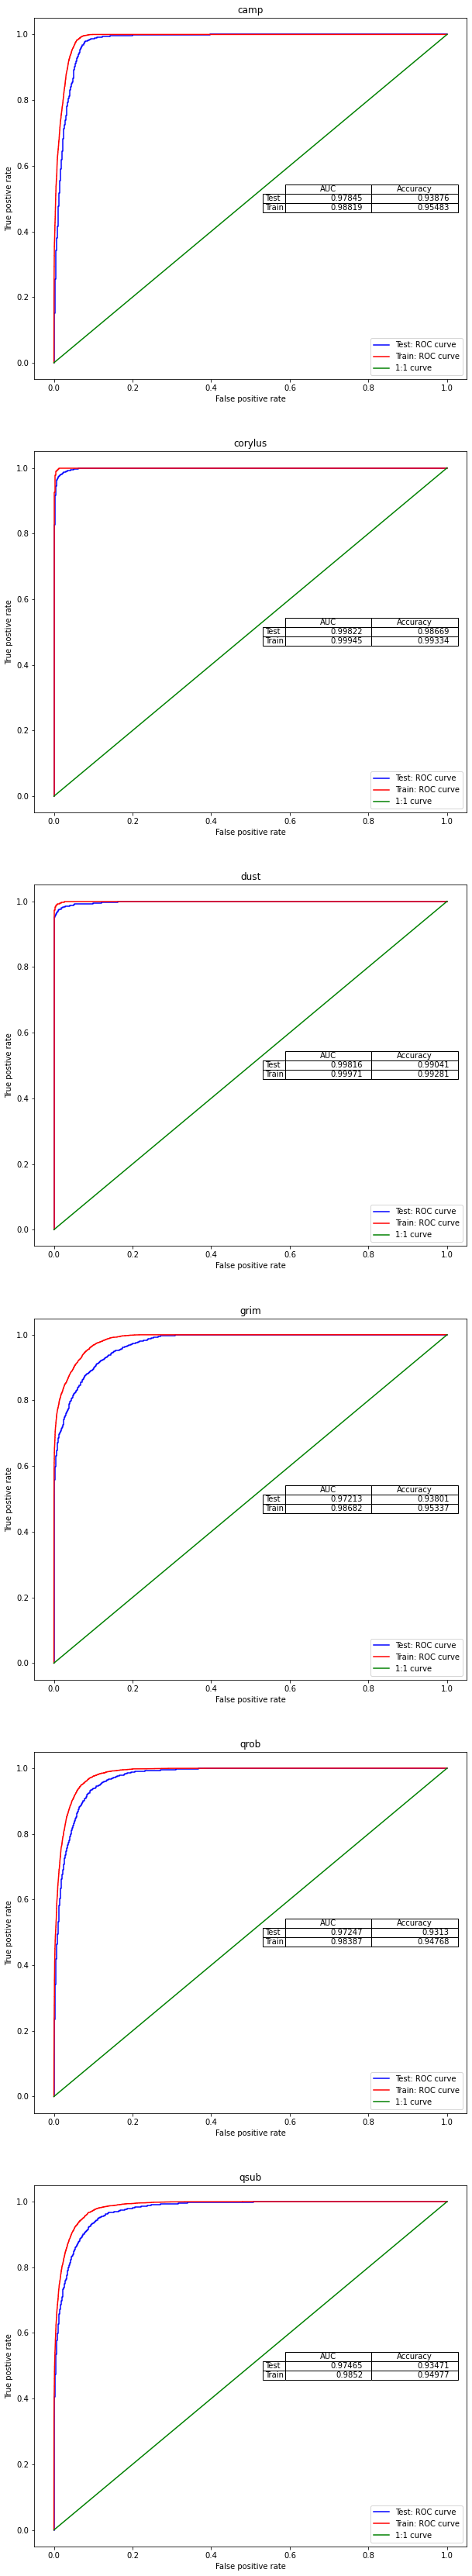

In [8]:
# Plotting the ROC curve, to test for overtaining and preformance
train_labels = tf.keras.utils.to_categorical(y_train, num_classes)
test_labels = tf.keras.utils.to_categorical(y_test, num_classes)

title = path
fig1, ax1 = plt.subplots(figsize=(10,10*num_classes), nrows=num_classes)
for i in range(num_classes):
    fpr,tpr, threshold =sklearn.metrics.roc_curve(test_labels[:,i],ypred_test[:,i])
    ax1[i].plot(fpr,tpr,'b', label='Test: ROC curve')

    fpr_train,tpr_train, threshold_train =sklearn.metrics.roc_curve(train_labels[:,i],ypred_train[:,i])
    ax1[i].plot(fpr_train,tpr_train,'r', label='Train: ROC curve')
    ax1[i].plot(np.linspace(0,1,100),np.linspace(0,1,100),'g', label='1:1 curve')
    ax1[i].set(xlabel='False positive rate',ylabel='True postive rate',title=title[i])
    ax1[i].legend()


    # The AUC and accuracy is computed and printed in the figure
    auc_score_train = auc(fpr_train,tpr_train)   
    auc_score_test = auc(fpr,tpr)   

    acc_score_train = accuracy_score(train_labels[:,i],np.where(ypred_train[:,i] > 0.5, 1, 0))
    acc_score_test = accuracy_score(test_labels[:,i],np.where(ypred_test[:,i] > 0.5, 1, 0))

    row_labels=['Test',
            'Train']
    table_vals=[[round(auc_score_test,5),round(acc_score_test,5)],
            [round(auc_score_train,5),round(acc_score_train,5)]]
    col_labels=['AUC','Accuracy']
    the_table = ax1[i].table(cellText=table_vals,
                  colWidths = [0.2]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')

### Inference

In [9]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1),
                                       predictions=np.argmax(ypred_test, axis = 1),
                                       num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate
print(error_rate)
print(inf_acc)

Confusion Matrix:  tf.Tensor(
[[1480    9    4   99    4    1]
 [  11 1473    0    3   28    4]
 [  53    0 1492   20    0    0]
 [ 374    6   12 1123   28   15]
 [  12   34    0   16 1271  220]
 [   7   34    0   22  316 1218]], shape=(6, 6), dtype=int32)
0.16532208017872657
0.8346779198212735


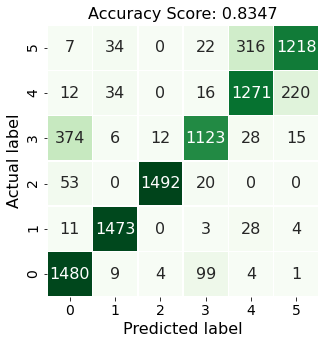

Correct: 8057/9389
Wrong: 1332/9389


In [11]:
plt.figure(figsize=(10,5))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

### Unsupervised learning

In [7]:
import umap
reducer_raw = umap.UMAP()
d = 20000
x_train_scale = StandardScaler().fit_transform(x_train[:d])

reducer_raw.fit(x_train_scale)

UMAP(dens_frac=0.0, dens_lambda=0.0)

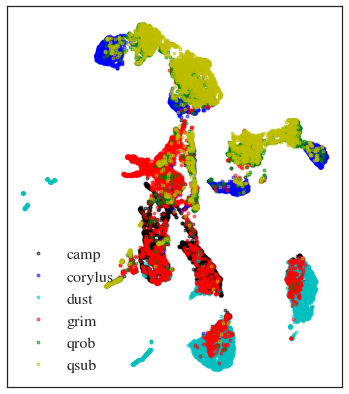

In [11]:
umap_transformed_images = reducer_raw.transform(x_train_scale)

y_train_scale = y_train[:d]
f_0 = umap_transformed_images[y_train_scale == 0] 
f_1 = umap_transformed_images[y_train_scale == 1] 
f_2 = umap_transformed_images[y_train_scale == 2] 
f_3 = umap_transformed_images[y_train_scale == 3] 
f_4 = umap_transformed_images[y_train_scale == 4] 
f_5 = umap_transformed_images[y_train_scale == 5] 

fig, ax = plt.subplots(figsize=(6,7))
reset_plt(16,16)
trans=0.5
ax.plot(f_0[:,0],f_0[:,1],'k.', label = path[0],alpha=trans)
ax.plot(f_1[:,0],f_1[:,1],'b.', label = path[1],alpha=trans)
ax.plot(f_2[:,0],f_2[:,1],'c.', label = path[2],alpha=trans)
ax.plot(f_3[:,0],f_3[:,1],'r.', label = path[3],alpha=trans)
ax.plot(f_4[:,0],f_4[:,1],'g.', label = path[4],alpha=trans)
ax.plot(f_5[:,0],f_5[:,1],'y.', label = path[5],alpha=trans)

x_axis = ax.get_xaxis()
x_axis.set_visible(False)
y_axis = ax.get_yaxis()
y_axis.set_visible(False)

ax.legend(loc=3)
fig.savefig('6model_umap.png',dpi=350)

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(2)

d = 15000
x_train_scale = StandardScaler().fit_transform(x_train[:d])
y_train_scale = y_train[:d]

tsne_transformed = tsne.fit_transform(x_train_scale)

f_0 = tsne_transformed[y_train_scale == 0] 
f_1 = tsne_transformed[y_train_scale == 1] 
f_2 = tsne_transformed[y_train_scale == 2] 
f_3 = tsne_transformed[y_train_scale == 3]
f_4 = tsne_transformed[y_train_scale == 4]
f_5 = tsne_transformed[y_train_scale == 5]

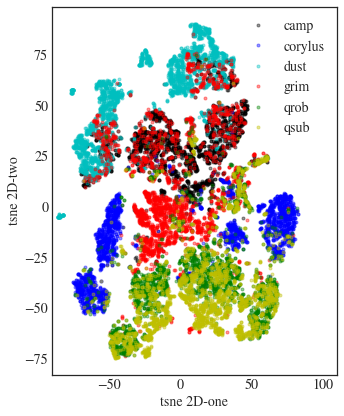

In [21]:
fig, ax = plt.subplots(figsize=(5,6))
reset_plt(14,14)
trans=0.4
ax.plot(f_0[:,0],f_0[:,1],'k.', label = path[0],alpha=trans)
ax.plot(f_1[:,0],f_1[:,1],'b.', label = path[1],alpha=trans)
ax.plot(f_2[:,0],f_2[:,1],'c.', label = path[2],alpha=trans)
ax.plot(f_3[:,0],f_3[:,1],'r.', label = path[3],alpha=trans)
ax.plot(f_4[:,0],f_4[:,1],'g.', label = path[4],alpha=trans)
ax.plot(f_5[:,0],f_5[:,1],'y.', label = path[5],alpha=trans)
ax.set(xlabel='tsne 2D-one',ylabel='tsne 2D-two',xlim=(-90,110))
ax.legend()
plt.tight_layout()
fig.savefig('6model_tsne.png',dpi=750)

### Feature importance

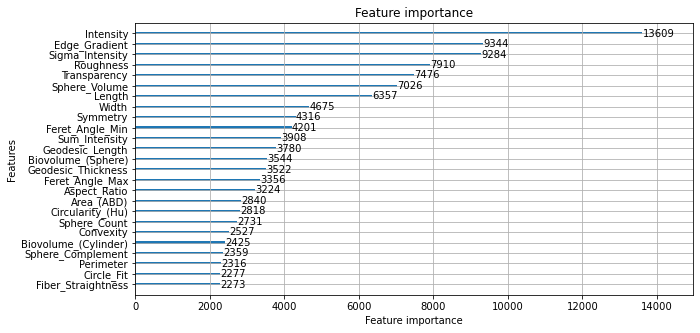

In [12]:
# Determine the feature importance for the algorithm
fig, ax = plt.subplots(figsize=(10,5))
lgb.plot_importance(lgbm,max_num_features=25, ax=ax)
index = lgbm.feature_importance()

# Extract the ranking into a list
feat_lgbm = []
for i in range(25):
    j = np.argmax(index)
    feat_lgbm.append(df_dust.columns[j])
    index[j] = 0

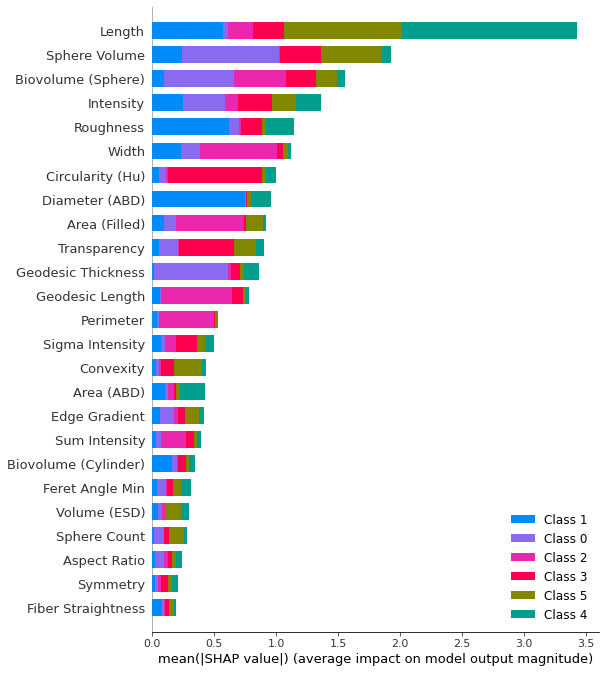

In [13]:
# explain the model's predictions using SHAP ranking
shap.initjs()
explainer = shap.Explainer(lgbm)
shap_value_plot = explainer.shap_values(x_train)
shap_value = explainer(x_train)
shap.summary_plot(shap_value_plot, x_train, max_display=25)

# Extract the ranking into a list
val = np.mean(np.abs(shap_value_plot[1]), axis=0)
shap_lgbm = []
for i in range(25):
    j = np.argmax(val)
    shap_lgbm.append(df_dust.columns[j])
    val[j] = 0

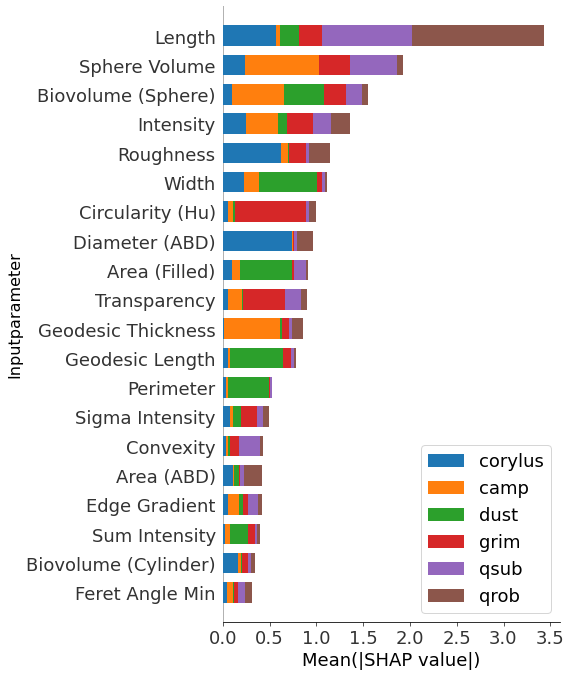

In [14]:
shap.summary_plot(shap_value_plot, x_train, max_display=20, color=plt.get_cmap("tab10"), show=False)
fig = plt.gcf()
fig.subplots_adjust(bottom=0.15)
#fig.set_figheight(12)
#fig.set_figwidth(14)
ax = plt.gca()
ax.set_xlabel(r'Mean(|SHAP value|)', fontsize=18)
ax.set_ylabel('Inputparameter', fontsize=16)
#ylabels = string_latexer([tick.get_text() for tick in ax.get_yticklabels()])
#ax.set_yticklabels(ylabels)
leg = ax.legend(prop={'size':18})

for l in leg.get_texts():
    ind = int(l.get_text()[-1])
    l.set_text(l.get_text().replace('Class '+str(ind),path[ind]))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(18)
    
plt.tight_layout()
plt.show()

fig.savefig('6model_shap',dpi=750)

In [15]:
# Comparing the Shap ranking and feature importance ranking

# Setting the data set and label format 
train_data_shap=lgb.Dataset(x_train[shap_lgbm],label=y_train)
train_data_feat=lgb.Dataset(x_train[feat_lgbm],label=y_train)
val_data_shap=lgb.Dataset(x_val[shap_lgbm],label=y_val)
val_data_feat=lgb.Dataset(x_val[feat_lgbm],label=y_val)

# Training the algorithm using the two different rankings
lgbm_shap=lgb.train(param,train_data_shap,valid_sets=[val_data_shap],early_stopping_rounds=50, verbose_eval=1);
lgbm_feat=lgb.train(param,train_data_feat,valid_sets=[val_data_feat],early_stopping_rounds=50, verbose_eval=1);

#predicting on test set for both ranking for comaprances
ypred_shap =lgbm_shap.predict(x_test[shap_lgbm])
ypred_feat =lgbm_feat.predict(x_test[feat_lgbm])

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4109
[LightGBM] [Info] Number of data points in the train set: 30044, number of used features: 25
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.792026
[LightGBM] [Info] Start training from score -1.790628
[LightGBM] [Info] Start training from score -1.793225
[LightGBM] [Info] Start training from score -1.793825
[LightGBM] [Info] Start training from score -1.790429
[LightGBM] [Info] Start training from score -1.790429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's multi_logloss: 1.35858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's multi_logloss: 1.33988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	valid_0's multi_logloss: 1.07348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	valid_0's multi_logloss: 1.06165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[55]	valid_0's multi_logloss: 0.886192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[56]	valid_0's multi_logloss: 0.878045
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's multi_logloss: 0.761175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's multi_logloss: 0.755337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's multi_logloss: 0.670057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's multi_logloss: 0.665786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's multi_logloss: 0.571826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's multi_logloss: 0.569097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's multi_logloss: 0.500127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's multi_logloss: 0.498355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[168]	valid_0's multi_logloss: 0.473486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's multi_logloss: 0.472134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's mult

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's multi_logloss: 0.438224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's multi_logloss: 0.437287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's multi_logloss: 0.422245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's multi_logloss: 0.421507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[235]	valid_0's multi_logloss: 0.410417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's multi_logloss: 0.409779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's mult

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's multi_logloss: 0.398553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's multi_logloss: 0.398038
[LightGBM] [Warning]

[273]	valid_0's multi_logloss: 0.389777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's multi_logloss: 0.38931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's multi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's multi_logloss: 0.381915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's multi_logloss: 0.381559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[310]	valid_0's multi_logloss: 0.37631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's multi_logloss: 0.376023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[312]	valid_0's multi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	valid_0's multi_logloss: 0.37094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	valid_0's multi_logloss: 0.370705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's multi_logloss: 0.366265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's multi_logloss: 0.366041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[368]	valid_0's multi_logloss: 0.362746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's multi_logloss: 0.362553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[402]	valid_0's multi_logloss: 0.35721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	valid_0's multi_logloss: 0.357061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[420]	valid_0's multi_logloss: 0.354783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's multi_logloss: 0.354681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's multi_logloss: 0.352681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's multi_logloss: 0.352591
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's multi_logloss: 0.35089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[461]	valid_0's multi_logloss: 0.350809
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[478]	valid_0's multi_logloss: 0.349461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[479]	valid_0's multi_logloss: 0.349389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's multi_logloss: 0.347942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's multi_logloss: 0.347862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's multi_logloss: 1.41841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	valid_0's multi_logloss: 1.39803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's multi_logloss: 1.13628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's multi_logloss: 1.12307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[48]	valid_0's multi_logloss: 0.946495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's multi_logloss: 0.937257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's multi_l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's multi_logloss: 0.727051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's multi_logloss: 0.721762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's multi_logloss: 0.591558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's multi_logloss: 0.588456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's multi_logloss: 0.515735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's multi_logloss: 0.513704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's multi_logloss: 0.483714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's multi_logloss: 0.482145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's multi_logloss: 0.459855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's multi_logloss: 0.458627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's multi_logloss: 0.43893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's multi_logloss: 0.437996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's multi_logloss: 0.422461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's multi_logloss: 0.421703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's multi_logloss: 0.409676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's multi_logloss: 0.409025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	valid_0's multi_logloss: 0.398137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's multi_logloss: 0.397545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's multi_logloss: 0.38895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's multi_logloss: 0.388461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	valid_0's multi_logloss: 0.380615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	valid_0's multi_logloss: 0.380255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[308]	valid_0's multi_logloss: 0.374143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's multi_logloss: 0.373841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's mult

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's multi_logloss: 0.368628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's multi_logloss: 0.368367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's multi_logloss: 0.364101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's multi_logloss: 0.363872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[366]	valid_0's multi_logloss: 0.360168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's multi_logloss: 0.359981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	valid_0's multi_logloss: 0.356909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[386]	valid_0's multi_logloss: 0.356748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	valid_0's multi_logloss: 0.354008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	valid_0's multi_logloss: 0.353859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's multi_logloss: 0.351412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's multi_logloss: 0.351289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's multi_logloss: 0.349294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	valid_0's multi_logloss: 0.349213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[462]	valid_0's multi_logloss: 0.347465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[463]	valid_0's multi_logloss: 0.347362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	valid_0's multi_logloss: 0.345828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[482]	valid_0's multi_logloss: 0.345743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's multi_logloss: 0.344299
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.344299


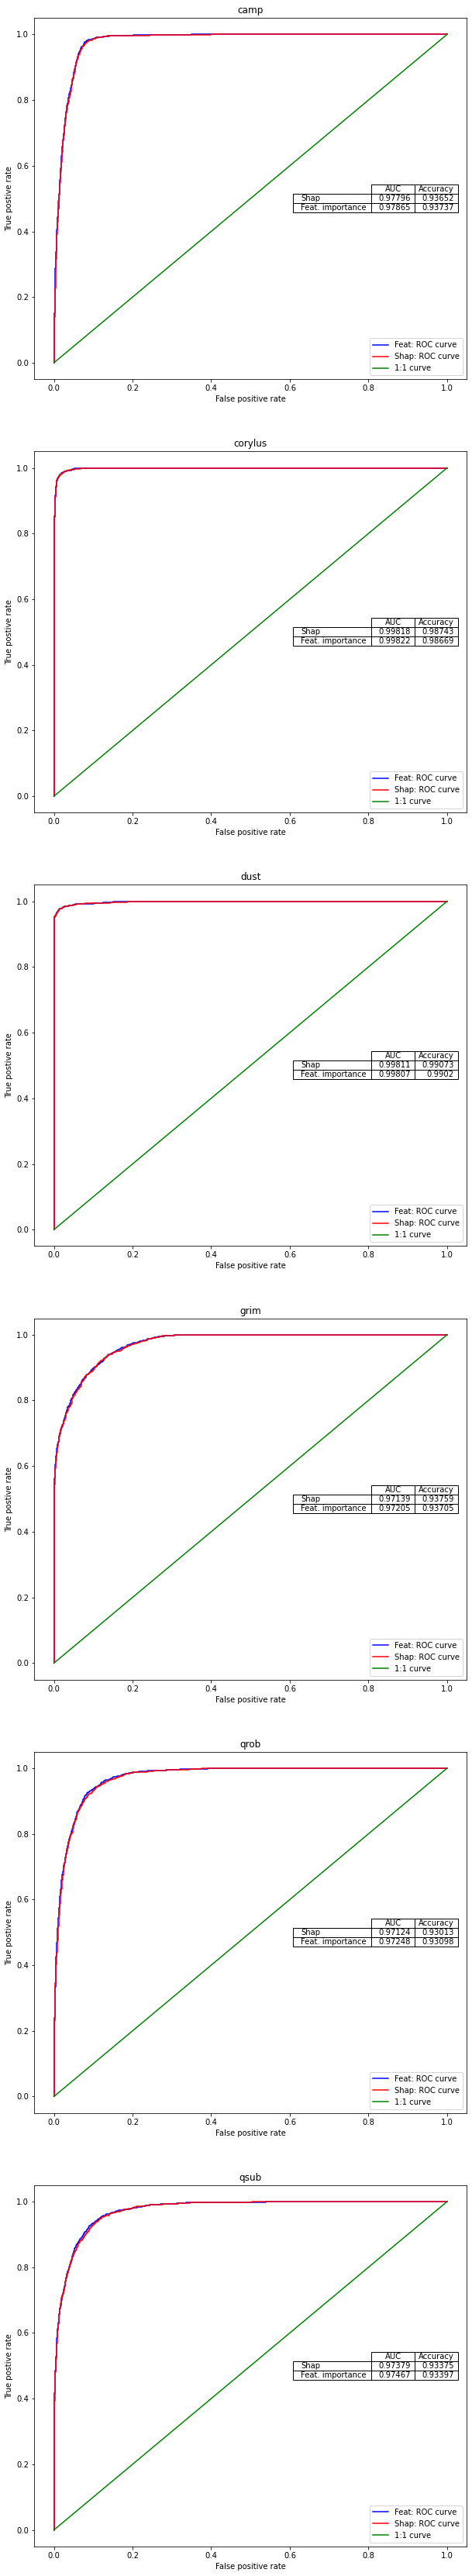

In [16]:
# Plotting the ROC curve, to test for overtaining and preformance
test_labels = tf.keras.utils.to_categorical(y_test, num_classes)

title = path
fig1, ax1 = plt.subplots(figsize=(10,10*num_classes), nrows=num_classes)
for i in range(num_classes):
    fpr,tpr, threshold =sklearn.metrics.roc_curve(test_labels[:,i],ypred_feat[:,i])
    ax1[i].plot(fpr,tpr,'b', label='Feat: ROC curve')

    fpr_train,tpr_train, threshold_train =sklearn.metrics.roc_curve(test_labels[:,i],ypred_shap[:,i])
    ax1[i].plot(fpr_train,tpr_train,'r', label='Shap: ROC curve')
    ax1[i].plot(np.linspace(0,1,100),np.linspace(0,1,100),'g', label='1:1 curve')
    ax1[i].set(xlabel='False positive rate',ylabel='True postive rate',title=title[i])
    ax1[i].legend()


    # The AUC and accuracy is computed and printed in the figure
    auc_score_shap = auc(fpr_train,tpr_train)   
    auc_score_feat = auc(fpr,tpr)   
    acc_score_shap = accuracy_score(test_labels[:,i],np.where(ypred_shap[:,i] > 0.5, 1, 0))
    acc_score_feat = accuracy_score(test_labels[:,i],np.where(ypred_feat[:,i] > 0.5, 1, 0))
   
    row_labels=['Shap',
            'Feat. importance']
    table_vals=[[round(auc_score_shap,5),round(acc_score_shap,5)],
            [round(auc_score_feat,5),round(acc_score_feat,5)]]
    col_labels=['AUC','Accuracy']
    the_table = ax1[i].table(cellText=table_vals,
                  colWidths = [0.1]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')

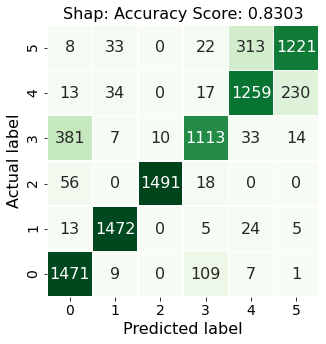

Shap, Correct: 8027/9389
Shap, Wrong: 1362/9389


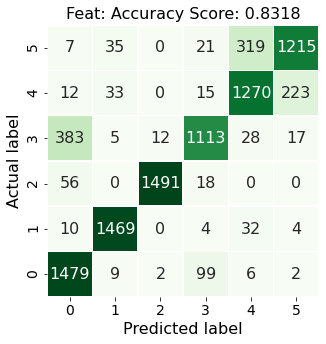

Feat, Correct: 8037/9389
Feat, Wrong: 1352/9389


In [17]:
conf_matrix_shap = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1),
                                       predictions=np.argmax(ypred_shap, axis = 1),
                                       num_classes=num_classes)
# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate_shap = (np.sum(conf_matrix_shap)-np.sum(np.diag(conf_matrix_shap))) / np.sum(np.diag(conf_matrix_shap))
inf_acc_shap = 1-error_rate_shap

plt.figure(figsize=(10,5))
ax = sns.heatmap(conf_matrix_shap, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Shap: Accuracy Score: {:.4f}'.format(inf_acc_shap), fontsize=16)
plt.show()

print('Shap, Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix_shap)),np.sum(conf_matrix_shap)))
print('Shap, Wrong: {0}/{1}'.format((np.sum(conf_matrix_shap)-np.sum(np.diag(conf_matrix_shap))),np.sum(conf_matrix_shap)))

conf_matrix_shap = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1),
                                       predictions=np.argmax(ypred_shap, axis = 1),
                                       num_classes=num_classes)
# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

conf_matrix_feat = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1),
                                       predictions=np.argmax(ypred_feat, axis = 1),
                                       num_classes=num_classes)

# Accuracy score for inference
error_rate_feat = (np.sum(conf_matrix_feat)-np.sum(np.diag(conf_matrix_feat))) / np.sum(np.diag(conf_matrix_feat))
inf_acc_feat = 1-error_rate_feat

plt.figure(figsize=(10,5))
ax = sns.heatmap(conf_matrix_feat, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Feat: Accuracy Score: {:.4f}'.format(inf_acc_feat), fontsize=16)
plt.show()

print('Feat, Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix_feat)),np.sum(conf_matrix_feat)))
print('Feat, Wrong: {0}/{1}'.format((np.sum(conf_matrix_feat)-np.sum(np.diag(conf_matrix_feat))),np.sum(conf_matrix_feat)))